# Tensorflow speech recognition challenge (Kaggle)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Input, layers
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
tf.__version__

'2.2.0'

In [0]:
data_path = "drive/My Drive/Colab Notebooks/data/preprocessed"
os.listdir(data_path)

['sample_submission.csv',
 'wav_all.npy',
 'label_all.npy',
 'unknown_wav.npy',
 'background_wav.npy',
 'test_wav_final.npy',
 'model-089-0.875049.h5',
 'submission.csv']

In [0]:
wav_all = np.load(os.path.join(data_path, "wav_all.npy"), allow_pickle=True)
wav_all = np.array([list(arr) for arr in wav_all])

label_all = np.load(os.path.join(data_path, "label_all.npy")).reshape(-1)

unknown_wav = np.load(os.path.join(data_path, "unknown_wav.npy"))
background_wav = np.load(os.path.join(data_path, "background_wav.npy"), allow_pickle=True)

---
### Generating training data
#### Generating silence samples from background noise
Since we have around 2131 of every label in our dataset, we will generate 2131 additional samples from background noise (and label it silence, because it doesn't contain any speech).

In [0]:
n_silence_samples = 41115

In [0]:
def get_noise_sample(noise_num=0):
    """Gets random sample from selected noise type (one out of 6)"""
    selected_noise = background_wav[noise_num]
    start_idx = random.randint(0, len(selected_noise)- 1 - 8000)
    return selected_noise[start_idx:(start_idx + 8000)]

In [0]:
#silence audio
silence_wav = []
n_samples_per_noise = n_silence_samples // len(background_wav)
for i, _ in enumerate(background_wav):
    for _ in range(n_samples_per_noise):
        silence_wav.append(get_noise_sample(i))
silence_wav = np.array(silence_wav)
silence_label = np.array(['silence' for _ in range(n_samples_per_noise * len(background_wav))])
silence_wav.shape

(41112, 8000)

#### Creating samples of unknown speech
Samples form all other labels. 

In [0]:
unknown_wav.shape

(41115, 8000)

In [0]:
unknown_wav = np.array(random.sample(list(unknown_wav), n_silence_samples))
unknown_label = ["unknown" for _ in range(n_silence_samples)]

---
#### Data Processing pipeline
The next step would be to create data processing pipeline: sample elements from the whole dataset instead of choosing fixed set of unknown samples and also doing data aumentation (mixing with noise) when doing training.

In [0]:
unknown_wav.shape, wav_all.shape, silence_wav.shape

((41115, 8000), (21312, 8000), (41112, 8000))

In [0]:
data = np.concatenate([wav_all, unknown_wav, silence_wav], 0)
labels = np.concatenate([label_all, unknown_label, silence_label], 0)

In [0]:
del(wav_all)
del(unknown_wav)
del(silence_wav)

In [0]:
# Converting labels to one hot vectors
label_values = np.unique(labels)
label_dict = {label: value for value, label in enumerate(sorted(label_values))}
label_dict

{'down': 0,
 'go': 1,
 'left': 2,
 'no': 3,
 'off': 4,
 'on': 5,
 'right': 6,
 'silence': 7,
 'stop': 8,
 'unknown': 9,
 'up': 10,
 'yes': 11}

In [0]:
label_all = [label_dict[label] for label in labels]
label_all = keras.utils.to_categorical(label_all, len(label_dict)).reshape(-1, 12, 1)
label_all.shape

(103539, 12, 1)

In [0]:
data.shape, labels.shape

((103539, 8000), (103539,))

In [0]:
train_wav, test_wav, train_label, test_label = train_test_split(data, label_all, test_size=0.2, random_state=42, shuffle=True)
del(data)  # saving RAM space

In [0]:
train_label.shape

(82831, 12, 1)

In [0]:
x_train = tf.data.Dataset.from_tensor_slices(train_wav)
y_train = tf.data.Dataset.from_tensor_slices(train_label.reshape([-1, 12]))

x_test = tf.data.Dataset.from_tensor_slices(test_wav)
y_test = tf.data.Dataset.from_tensor_slices(test_label.reshape([-1, 12]))

next(iter(y_test)).shape

TensorShape([12])

In [0]:
def get_noise_sample(noise_num=0):
    """Gets random sample from selected noise type (one out of 6)"""
    selected_noise = background_wav[noise_num]
    start_idx = random.randint(0, len(selected_noise)- 1 - 8000)
    return selected_noise[start_idx:(start_idx + 8000)]

In [0]:
# Defining data augmentation pipeline

def augment_convert(x):
    noise_ratio = random.random() / 2
    num = random.randint(0, 5)
    noise = get_noise_sample(num)
    noised_x = x + noise_ratio * noise
    return tf.reshape(noised_x, [8000, 1])

def convert(x):
    return tf.reshape(x, [8000, 1])

kwargs = dict(deterministic=False, num_parallel_calls=6)
train_dataset = tf.data.Dataset.zip((x_train.map(augment_convert), y_train)).batch(512).prefetch(100)
valid_dataset = tf.data.Dataset.zip((x_test.map(convert), y_test)).batch(512).prefetch(100)
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([512, 8000, 1]), TensorShape([512, 12]))

---
## Model

In [0]:
# Parameters
lr = 0.001
batch_size = 1024
dropout_rate = 0.5
input_shape = (8000,1)
best_model_path = '.best_val_model.hdf5'

In [0]:
# class weights
label_cnt = Counter(labels)
label_cnt

Counter({'down': 2152,
         'go': 2101,
         'left': 2165,
         'no': 2098,
         'off': 2143,
         'on': 2105,
         'right': 2155,
         'silence': 41112,
         'stop': 2174,
         'unknown': 41115,
         'up': 2062,
         'yes': 2157})

In [0]:
label_dict

{'down': 0,
 'go': 1,
 'left': 2,
 'no': 3,
 'off': 4,
 'on': 5,
 'right': 6,
 'silence': 7,
 'stop': 8,
 'unknown': 9,
 'up': 10,
 'yes': 11}

In [0]:
num_to_label = {value: key for key, value in label_dict.items()}
class_weight = {label_dict[key]: 2062 / value for key, value in label_cnt.items()}
class_weight

{0: 0.95817843866171,
 1: 0.9814374107567825,
 2: 0.9524249422632795,
 3: 0.982840800762631,
 4: 0.9622025198320112,
 5: 0.9795724465558194,
 6: 0.9568445475638051,
 7: 0.050155672309787895,
 8: 0.9484820607175714,
 9: 0.05015201264745227,
 10: 1.0,
 11: 0.9559573481687529}

In [0]:
# model = keras.models.load_model(os.path.join(data_path, "model-089-0.875049.h5"))
# model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.Adam(lr = lr),
#              metrics=['accuracy'])

#Conv1D Model
input_tensor = Input(shape=(input_shape))

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(10)(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.Flatten()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(drop_out_rate)(x)
# x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
output_tensor = layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr=lr),
             metrics=['accuracy'])


In [0]:
mcp_save = ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(train_dataset, validation_data=valid_dataset, class_weight=class_weight, shuffle=True, epochs=500, verbose=1, callbacks=[mcp_save])

Epoch 1/500
162/162 [==============================] - 17s 107ms/step - loss: 0.5537 - accuracy: 0.3759 - val_loss: 1.7815 - val_accuracy: 0.3741
Epoch 2/500
162/162 [==============================] - 17s 104ms/step - loss: 0.4902 - accuracy: 0.4264 - val_loss: 1.5982 - val_accuracy: 0.4272
Epoch 3/500
162/162 [==============================] - 17s 104ms/step - loss: 0.4315 - accuracy: 0.4563 - val_loss: 1.4403 - val_accuracy: 0.4293
Epoch 4/500
162/162 [==============================] - 17s 104ms/step - loss: 0.3862 - accuracy: 0.4796 - val_loss: 1.2640 - val_accuracy: 0.5300
Epoch 5/500
162/162 [==============================] - 17s 103ms/step - loss: 0.3400 - accuracy: 0.5114 - val_loss: 1.3448 - val_accuracy: 0.4954
Epoch 6/500
162/162 [==============================] - 17s 104ms/step - loss: 0.3036 - accuracy: 0.5442 - val_loss: 1.0941 - val_accuracy: 0.5864
Epoch 7/500
162/162 [==============================] - 17s 103ms/step - loss: 0.2808 - accuracy: 0.5639 - val_loss: 0.9732 -

In [0]:
# model = keras.models.load_model(best_model_path)

## Running model on test data

In [0]:
label_dict = {'down': 0,
            'go': 1,
            'left': 2,
            'no': 3,
            'off': 4,
            'on': 5,
            'right': 6,
            'silence': 7,
            'stop': 8,
            'unknown': 9,
            'up': 10,
            'yes': 11}

In [0]:
test_path = os.path.join(data_path, "test_wav_final.npy")
test_all = np.load(test_path).reshape(-1, 8000, 1)  # may take a while (~3 minutes) (it's almost 5GB)

In [0]:
test_all.shape

(158538, 8000, 1)

In [0]:
preds = model.predict(test_all)

In [0]:
preds.shape

(158538, 12)

In [0]:
num_to_label = {value: key for key, value in label_dict.items()}
num_to_label

{0: 'down',
 1: 'go',
 2: 'left',
 3: 'no',
 4: 'off',
 5: 'on',
 6: 'right',
 7: 'silence',
 8: 'stop',
 9: 'unknown',
 10: 'up',
 11: 'yes'}

In [0]:
predicted_labels = [num_to_label[num] for num in preds.argmax(1)]

In [0]:
submission_file = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))
submission_file["label"] = predicted_labels
submission_file.to_csv(os.path.join(data_path, "submission.csv"), index=False)

In [0]:
pd.read_csv(os.path.join(data_path, "submission.csv")).head()

,fname,label
0,clip_000044442.wav,no
1,clip_0000adecb.wav,unknown
2,clip_0000d4322.wav,no
3,clip_0000fb6fe.wav,silence
4,clip_0001d1559.wav,unknown


In [0]:
predicted_label_cnt = Counter(submission_file.label.values)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

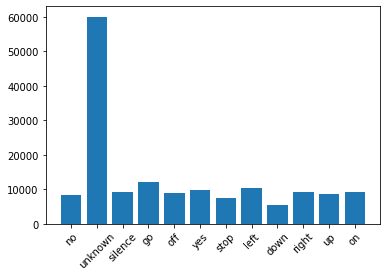

In [0]:
plt.bar(predicted_label_cnt.keys(), predicted_label_cnt.values())
plt.xticks(rotation=45)